# Active matter

Simulations of active matter include driving forces that force particles to move.

## Initialize

Import the hoomd python package and the md component to execute MD simulations.

In [1]:
import hoomd
import hoomd.md

Initialize the execution context to control where HOOMD will execute the simulation. When no command line options are provided, HOOMD will auto-select a GPU if it exists, or run on the CPU.

In [2]:
hoomd.context.initialize("");

HOOMD-blue v2.1.5 CUDA (7.5) DOUBLE HPMC_MIXED MPI SSE SSE2 SSE3 SSE4_1 SSE4_2 AVX 
Compiled: 03/09/2017
Copyright 2009-2016 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
notice(2): This system is not compute exclusive, using local rank to select GPUs
notice(2): Unable to identify node local rank information
notice(2): Using global rank to select GPUs
HOOMD-blue is running on the following GPU(s):
 [0]            Tesla K20c  13 SM_3.5 @ 0.706 GHz, 5060 MiB DRAM


Initialize a $n$ by $n$ by $n$ simple square lattice of particles. The lattice initializer by default creates all particles named type "A", and with 0 velocity.

In [3]:
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sq(a=1.4),
                                   n=15);
all = hoomd.group.all();
N = len(all);

notice(2): Group "all" created containing 225 particles


## Define potential energy

The WCA potential has the same functional form as Lennard-Jones, but $r_\mathrm{cut}=2^{1/6}\sigma$ and is shifted up to 0 at the cutoff.

Choose the neighbor list acceleration structure to find neighboring particles efficiently. In systems with only one cutoff length, the cell method performs best.

In [4]:
nl = hoomd.md.nlist.cell();

Define the functional form of the pair interaction and evaluate using the given neighbor list acceleration structure.

In [5]:
lj = hoomd.md.pair.lj(r_cut=2**(1/6), nlist=nl);
lj.set_params(mode='shift');

Specify pair potential parameters for every pair of types in the simulation.

In [6]:
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0);

In [7]:
import numpy
activity = [ ( ((numpy.random.rand(1)[0] - 0.5) * 2.0),
               ((numpy.random.rand(1)[0] - 0.5) * 2.0),
               0) 
             for i in range(N)];

In [8]:
hoomd.md.force.active(group=all,
                      seed=123,
                      f_lst=activity,
                      rotation_diff=0.005,
                      orientation_link=False);

## Select integrator

The integrator defines the equations of motion that govern the system of particles, given the current configuration of the particles and the net force from all potentials. The standard integration mode in HOOMD allows different integrators to apply to different groups of particles with the same step size $dt$.

In [9]:
hoomd.md.integrate.mode_standard(dt=0.001);

Apply the Brownian equations of motion to all particles. $kT$ defines the temperature of the system in energy units and *seed* defines the seed for the random number generator.

In [10]:
hoomd.md.integrate.brownian(group=all, kT=0.0, seed=123);

notice(2): integrate.langevin/bd is using specified gamma values


## Write output

Periodically write the particle configurations to a gsd file.

In [11]:
hoomd.dump.gsd("trajectory.gsd", period=500, group=all, overwrite=True);

## Run the simulation

Take 10,000 steps forward in time.

In [12]:
hoomd.run(10000);

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 225
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:01 | Step 10000 / 10000 | TPS 11080.1 | ETA 00:00:00
Average TPS: 10964.9
---------
-- Neighborlist stats:
43 normal updates / 35 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 6 / n_neigh_avg: 3.77778
shortest rebuild period: 99
-- Cell list stats:
Dimension: 13, 13, 1
n_min    : 0 / n_max: 3 / n_avg: 1.33136
** run complete **


## Examine the output

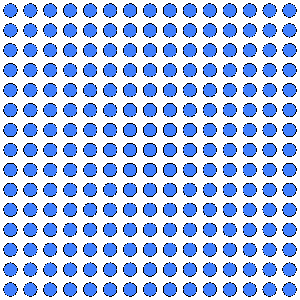

In [13]:
import ex_render
ex_render.display_movie(ex_render.render_disk_frame, 'trajectory.gsd');